In [1]:
%load_ext autoreload
%autoreload 2

import torch
import tqdm
import gpytorch


import numpy as np
from ase import io
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("../../fande") # Adds higher directory to python modules path.
sys.path.append("..") # Adds higher directory to python modules path.

In [3]:
path = os.getcwd()

print(path)

/home/dlb/coding/shared_coding/repos/chem-gp/saddle-dynamics/notebooks


In [4]:
from fande.data import FandeDataModule

fande.models module imported...
FandE-GP imported  
objects of fande.data module imported...


### Parsing and loading data:

In [7]:
%load_ext autoreload
%autoreload 2

from sdynamics.load import parse_trajectories, parse_forces, flatten_trj_dictionaries

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
trajectories, energies_trj, trj_files_basenames = parse_trajectories(traj_folder="../data/dynamics/ene_grad_fitting/data/trj/")
forces_trj = parse_forces(forces_path = '../data/dynamics/ene_grad_fitting/data/grad/', trj_files_basenames = trj_files_basenames)

Reading trajectory files...


100%|██████████| 50/50 [00:18<00:00,  2.64it/s]

Trajectory files reading done!
Reading .npy files with forces...
Reading .npy files with forces done!


In [9]:
traj, energies, forces = flatten_trj_dictionaries(trajectories, energies_trj, trj_files_basenames, forces_trj)

Flattening done!


### Prepare training/test datasets:

In [46]:
# XTB normal MD
from ase.visualize import view

traj_xtb_md = io.read("../data/dump/xtb_md/asemd.traj", index=":")
forces_xtb_md = np.load("../data/dump/xtb_md/forces_xtb_md.npy")
energies_xtb_md = np.load("../data/dump/xtb_md/energies_xtb_md.npy")

# Training data:
# training_indices = np.sort(  np.random.choice(np.arange(0,10_000), 1000, replace=False) )
training_indices = np.sort(  np.arange(0, 10_000, 200) )  
traj_train = [traj_xtb_md[i] for i in training_indices]
energies_train = energies_xtb_md[training_indices]
forces_train = forces_xtb_md[training_indices]
train_data = {'trajectory': traj_train, 'energies': energies_train, 'forces': forces_train}

#Test data:
# test_indices = np.sort(  np.random.choice(np.arange(0,92795), 200, replace=False) ) 
test_indices = np.sort(  np.arange(1,101,2) ) 
traj_test = [traj_xtb_md[i] for i in test_indices]
energies_test = energies_xtb_md[test_indices]
forces_test = forces_xtb_md[test_indices]
test_data = {'trajectory': traj_test, 'energies': energies_test, 'forces': forces_test}

In [15]:
# Training data:
# training_indices = np.sort(  np.random.choice(np.arange(0,10_000), 1000, replace=False) )
training_indices = np.sort(  np.arange(0, 90000, 200) )  
traj_train = [traj[i] for i in training_indices]
energies_train = energies[training_indices]
forces_train = forces[training_indices]
train_data = {'trajectory': traj_train, 'energies': energies_train, 'forces': forces_train}

#Test data:
# test_indices = np.sort(  np.random.choice(np.arange(0,92795), 200, replace=False) ) 
test_indices = np.sort(  np.arange(1,101,2) ) 
traj_test = [traj[i] for i in test_indices]
energies_test = energies[test_indices]
forces_test = forces[test_indices]
test_data = {'trajectory': traj_test, 'energies': energies_test, 'forces': forces_test}

(50, 17, 3)


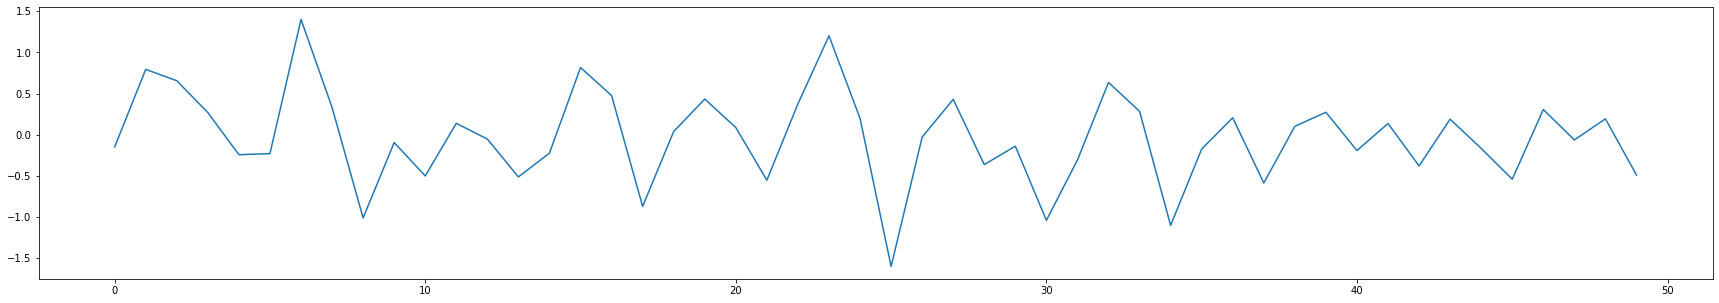

In [47]:
from fande.data import FandeDataModuleASE


hparams = {
    'dtype' : 'float64',
    'device' : 'gpu'
}

# del fdm

fdm = FandeDataModuleASE(train_data, test_data, hparams)

print(fdm.forces_train_norm.shape)
plt.plot(fdm.forces_train[:,16,0])

In [48]:
soap_params = {
    'species': ["H", "C"],
    'periodic': False,
    'rcut': 3.0,
    'sigma': 0.5,
    'nmax': 5,
    'lmax': 5,
    'average': "outer",
    'crossover': True,
    'dtype': "float64",
    'n_jobs': 10,
    'sparse': False,
    'positions': [0,2,3,6]
}

fdm.calculate_invariants(soap_params)

Total length of train traj is 50
Starting SOAP calculation...
SOAP calculation done!
Total length of test traj is 50
Starting SOAP calculation...
SOAP calculation done!
(50, 17, 3, 330)
(50, 330)


In [1216]:
fdm.train_DX.shape

torch.Size([22950, 330])

### Fitting Forces:

In [49]:
from fande.models import ModelForces, ModelEnergies, MyCallbacks
from torch.utils.data import DataLoader, TensorDataset, random_split
from pytorch_lightning import Trainer, seed_everything
import numpy as np
# seed_everything(42, workers=True)

train_DX = fdm.train_DX
train_F = fdm.train_F
test_DX = fdm.test_DX
test_F = fdm.test_F

# ind_slice = np.sort( np.concatenate( 
#     ( np.arange(0,4800), np.arange(11*4800,12*4800), np.random.choice(np.arange(4800,59200), 300, replace=False) ) 
#     ) )

# ind_slice = np.sort(  np.random.choice(np.arange(0,train_F.shape[0]), 1_000, replace=False) ) 
# ind_slice = np.sort(  np.arange(0,2550) ) 
ind_slice = np.sort(  np.arange(0,train_F.shape[0]) ) 


train_dataset = TensorDataset(train_DX[ind_slice], train_F[ind_slice])
train_loader = DataLoader(train_dataset, batch_size=100_000)

model_f = ModelForces(train_DX[ind_slice], train_F[ind_slice], hparams, 0.05)

trainer_f = Trainer(
    gpus=1, 
    max_epochs=150, 
    precision=64,
    weights_summary='full', 
    callbacks=[MyCallbacks()])

trainer_f.fit(model_f, train_loader)

/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:187: LightningDeprecationWarning:

Setting `Trainer(weights_summary=full)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.model_summary.ModelSummary` with `max_depth` directly to the Trainer's `callbacks` argument instead.

/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:394: UserWarning:

The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for lo


 setup() callback called...
Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, loss=0.676, v_num=193]

 teardown() callback called...


### Predictions on test data:

/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.




 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...


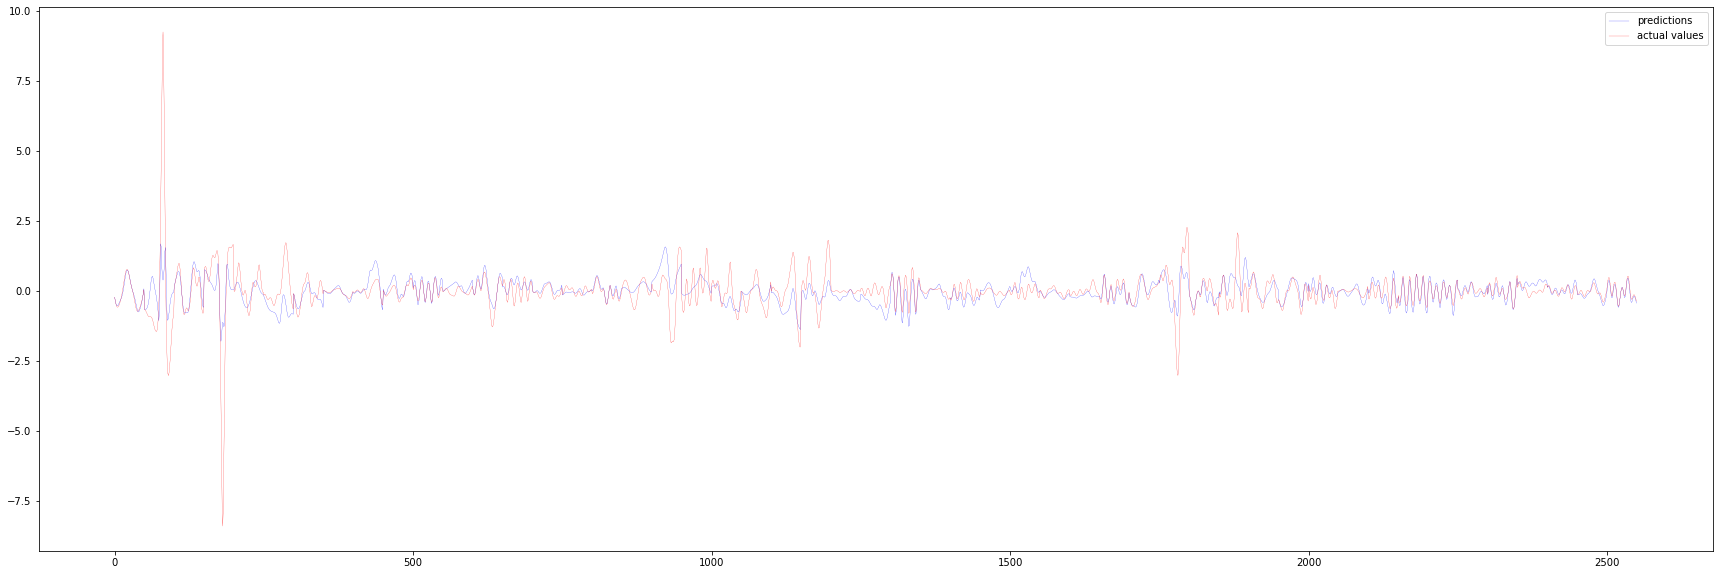

Forces MAE: 0.3043
Forces MSE: 0.3801


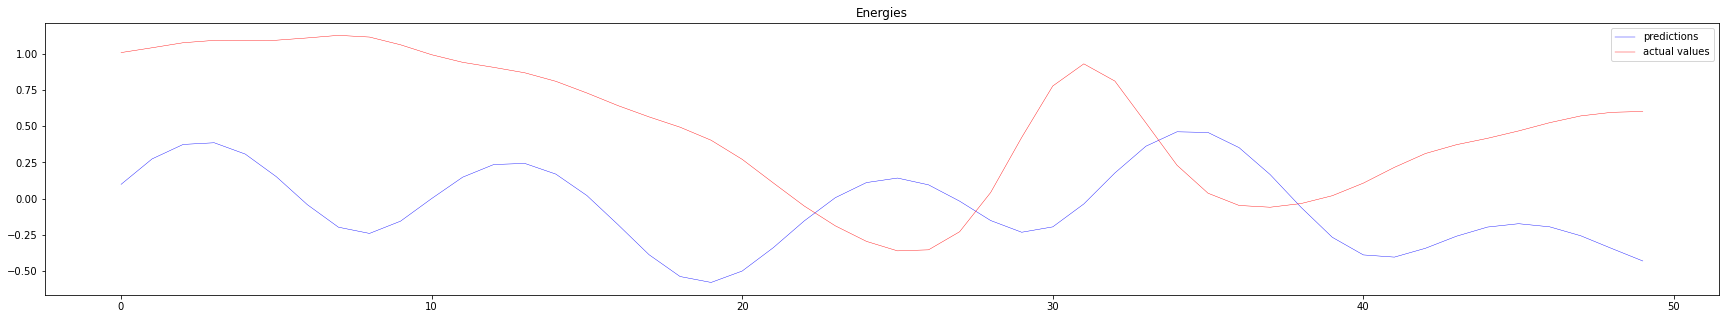

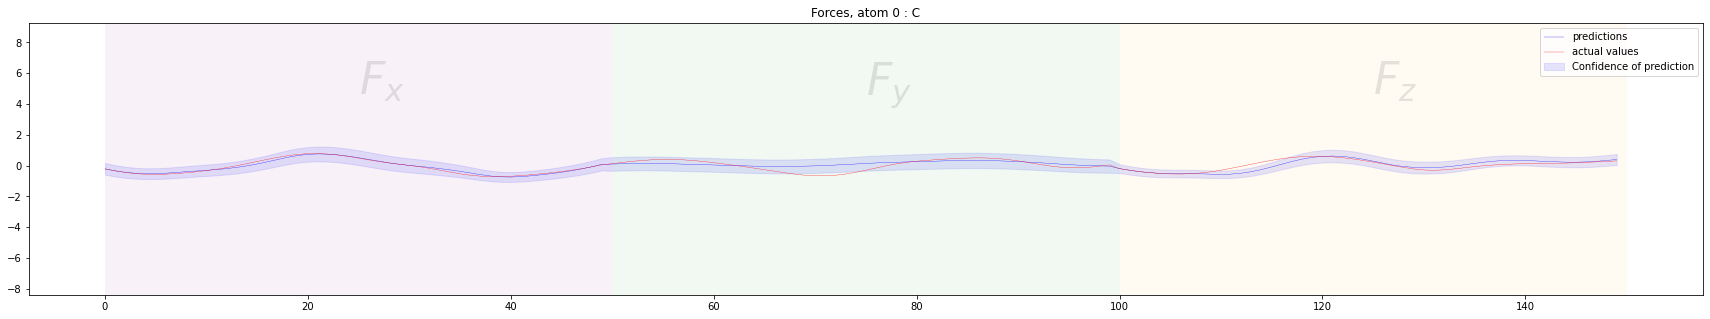

Forces MAE: 0.1398
Forces MSE: 0.0417
Cumulative uncertainty: 119.4520


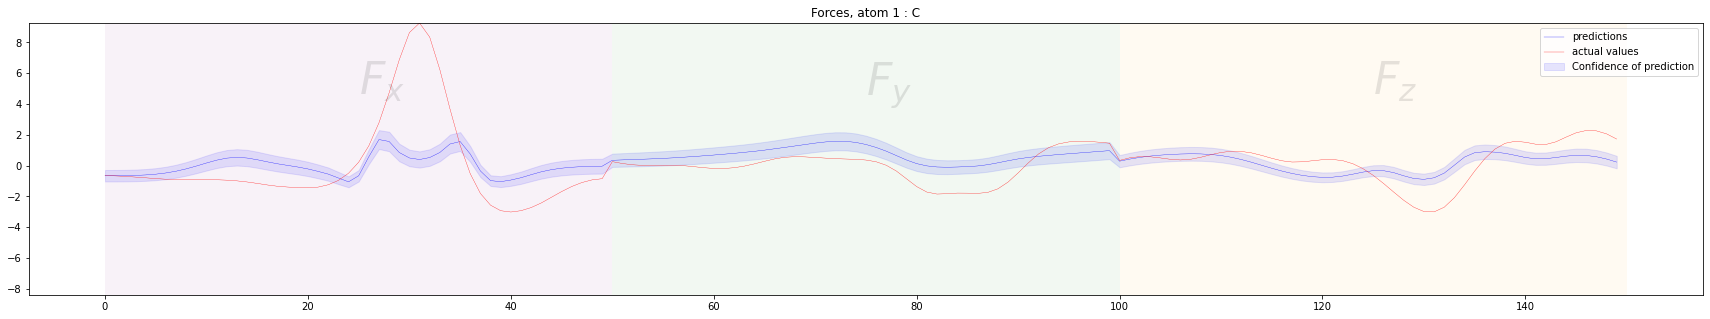

Forces MAE: 1.1851
Forces MSE: 3.0877
Cumulative uncertainty: 137.7571


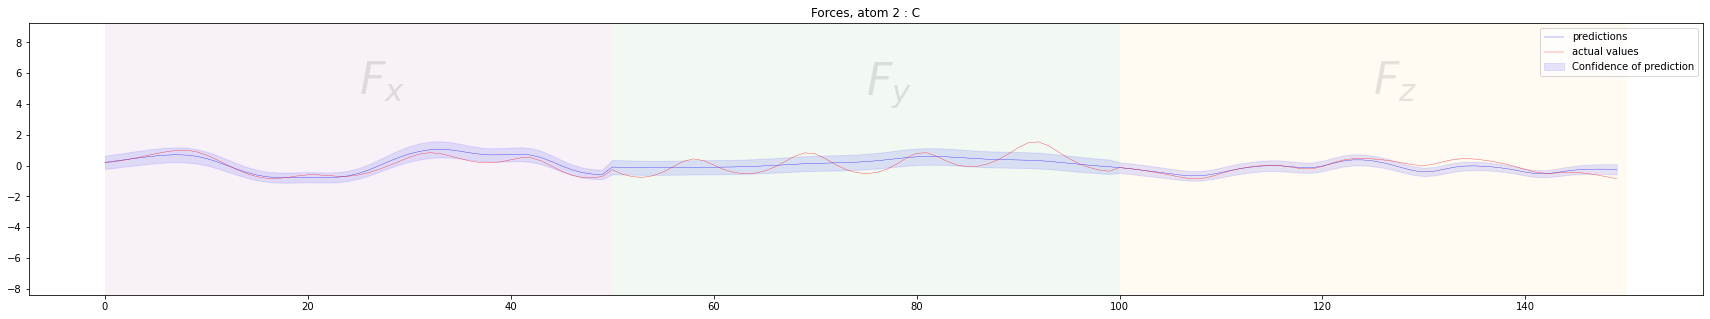

Forces MAE: 0.2697
Forces MSE: 0.1262
Cumulative uncertainty: 120.8487


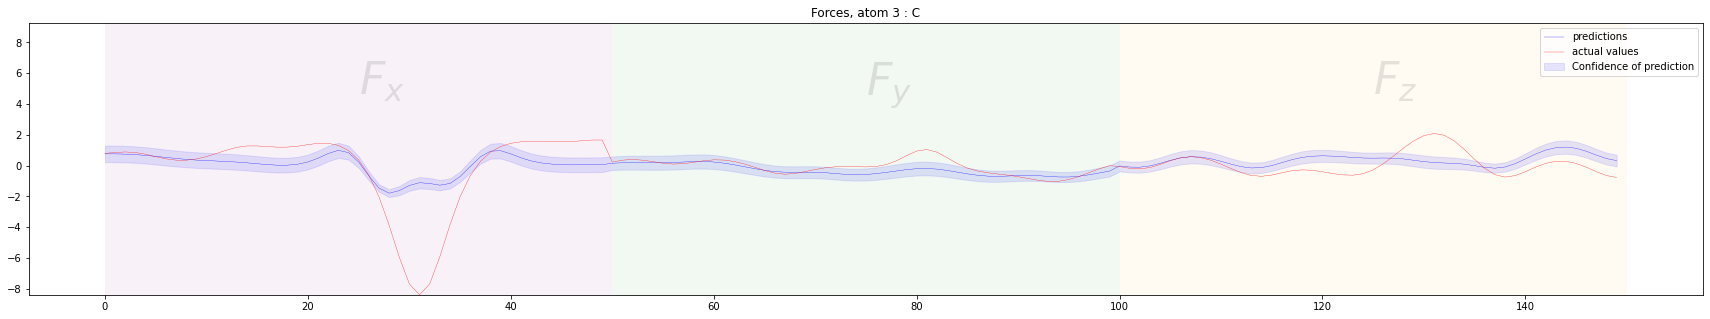

Forces MAE: 0.7615
Forces MSE: 1.7859
Cumulative uncertainty: 123.2133


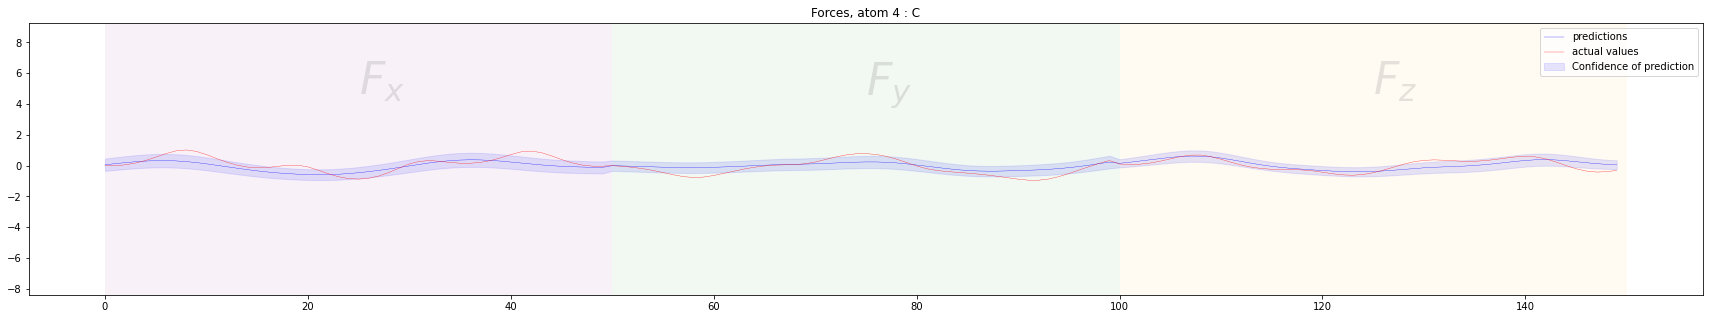

Forces MAE: 0.2756
Forces MSE: 0.1162
Cumulative uncertainty: 110.4274


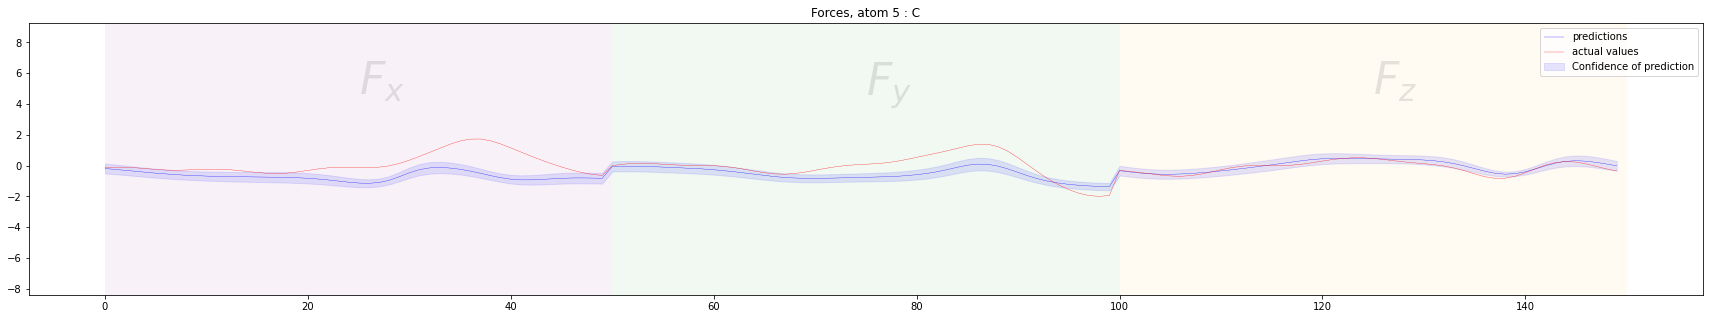

Forces MAE: 0.5137
Forces MSE: 0.5307
Cumulative uncertainty: 91.0029


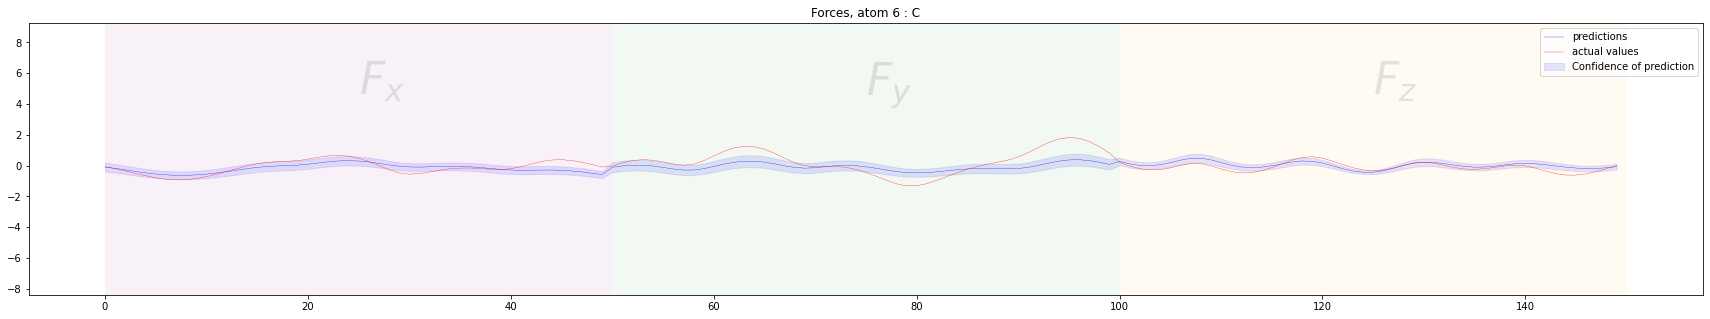

Forces MAE: 0.3560
Forces MSE: 0.2233
Cumulative uncertainty: 81.1414


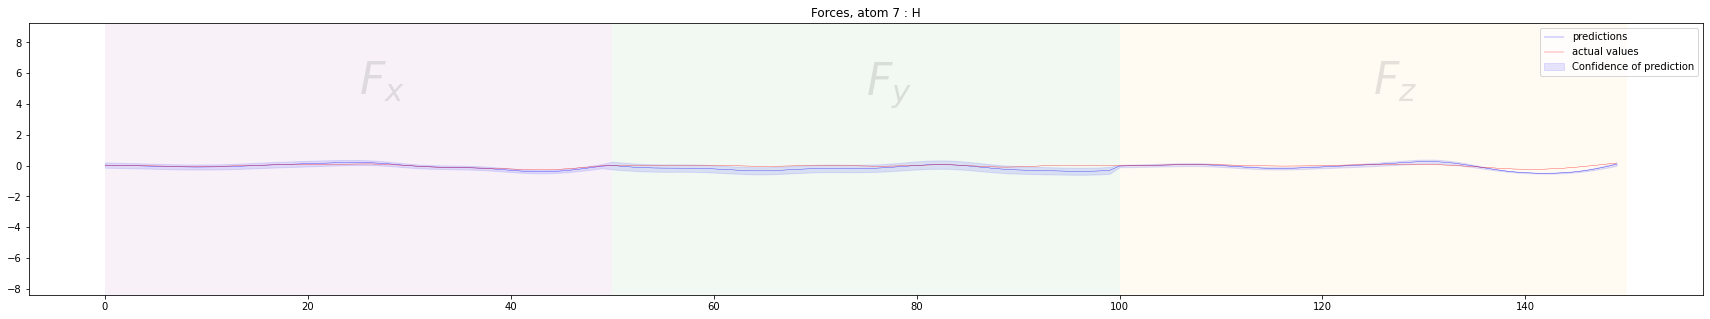

Forces MAE: 0.1131
Forces MSE: 0.0232
Cumulative uncertainty: 47.3558


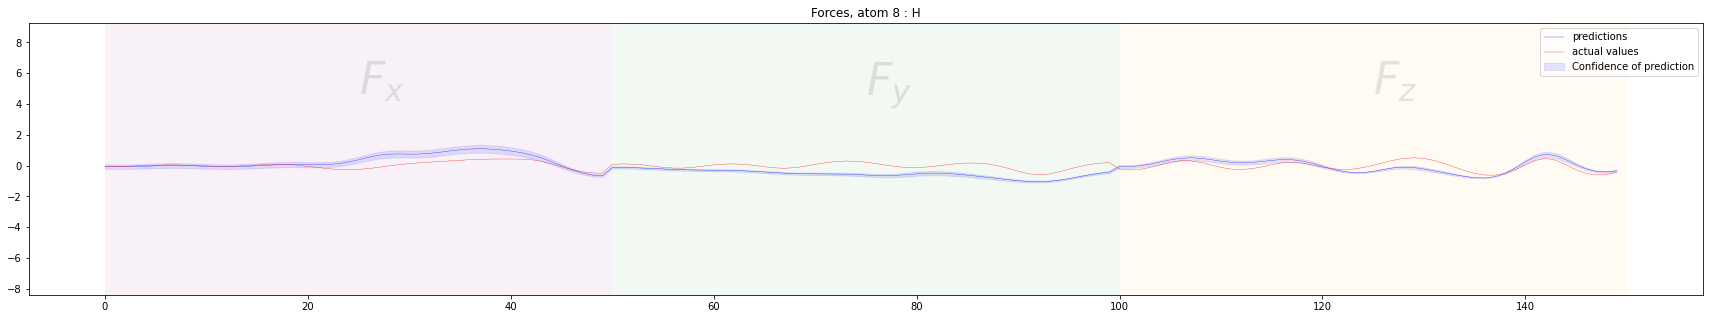

Forces MAE: 0.3571
Forces MSE: 0.1897
Cumulative uncertainty: 35.8425


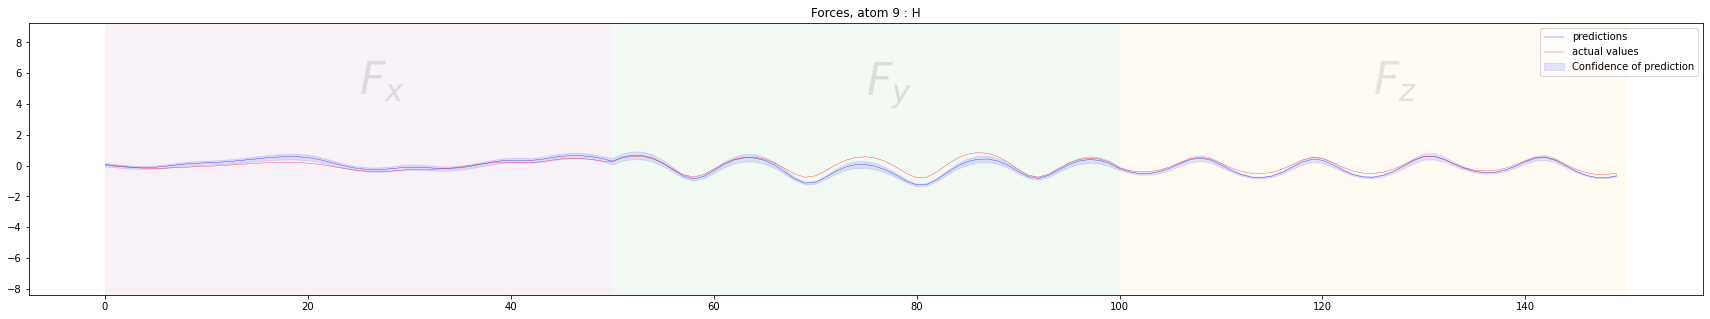

Forces MAE: 0.1751
Forces MSE: 0.0501
Cumulative uncertainty: 42.0115


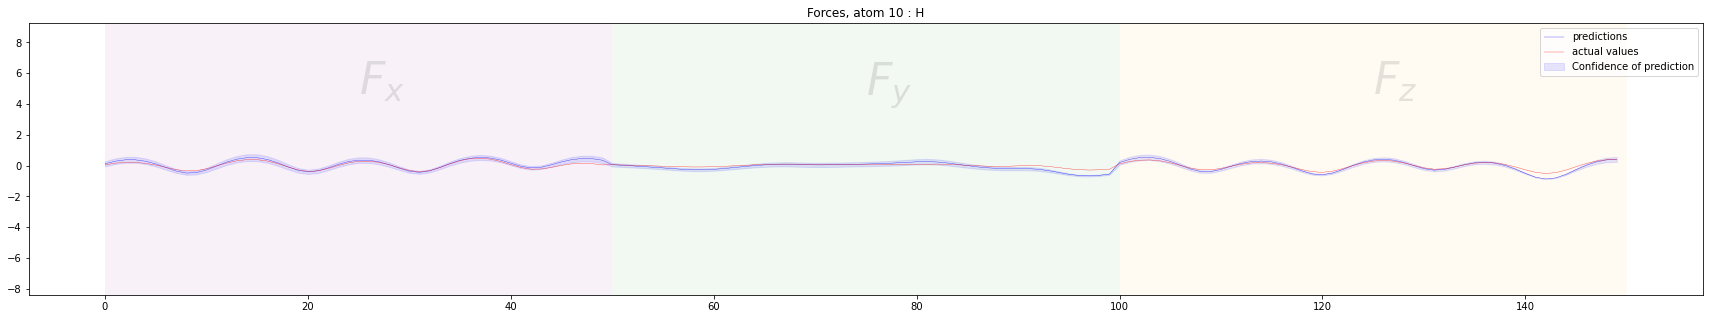

Forces MAE: 0.1036
Forces MSE: 0.0193
Cumulative uncertainty: 36.9116


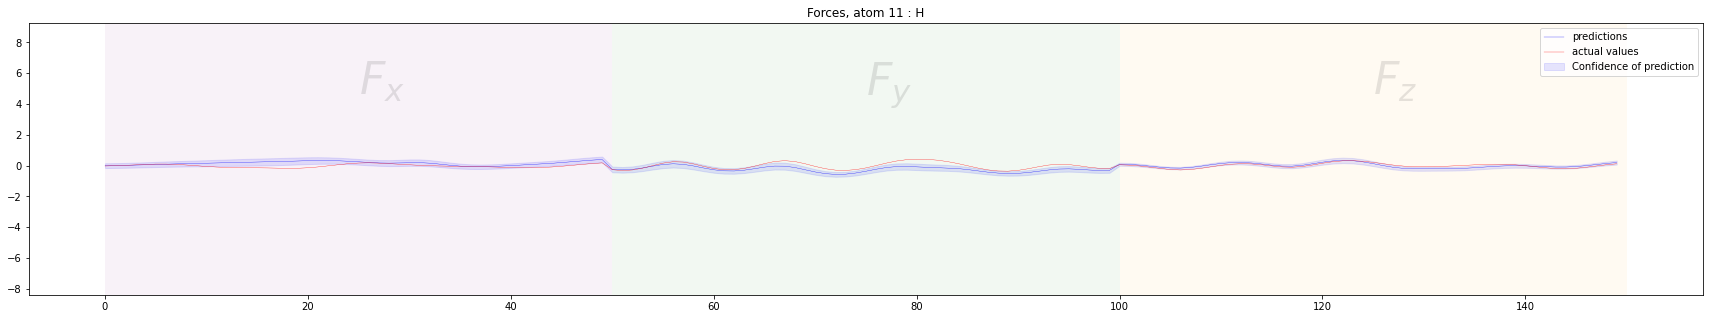

Forces MAE: 0.1654
Forces MSE: 0.0434
Cumulative uncertainty: 49.5055


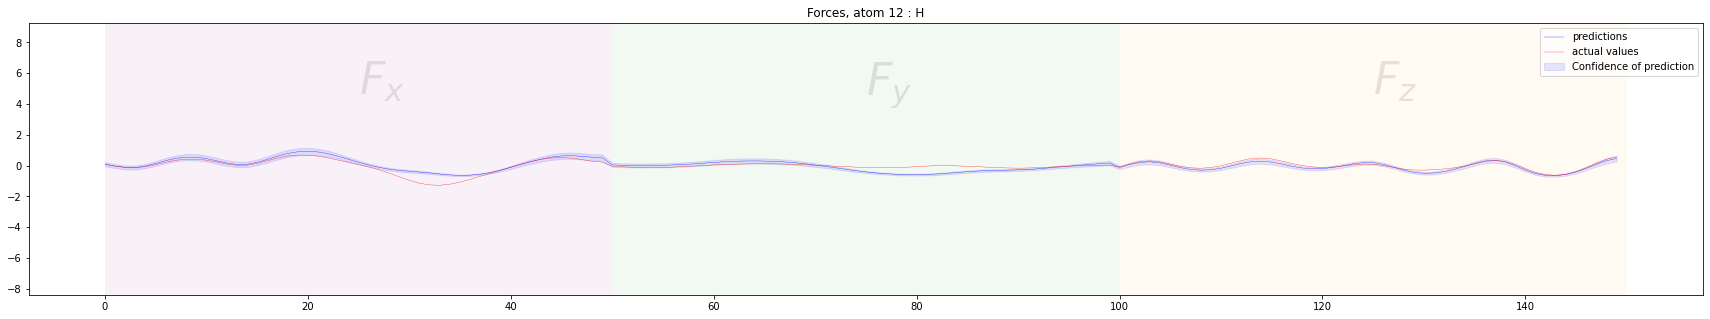

Forces MAE: 0.1594
Forces MSE: 0.0487
Cumulative uncertainty: 37.7269


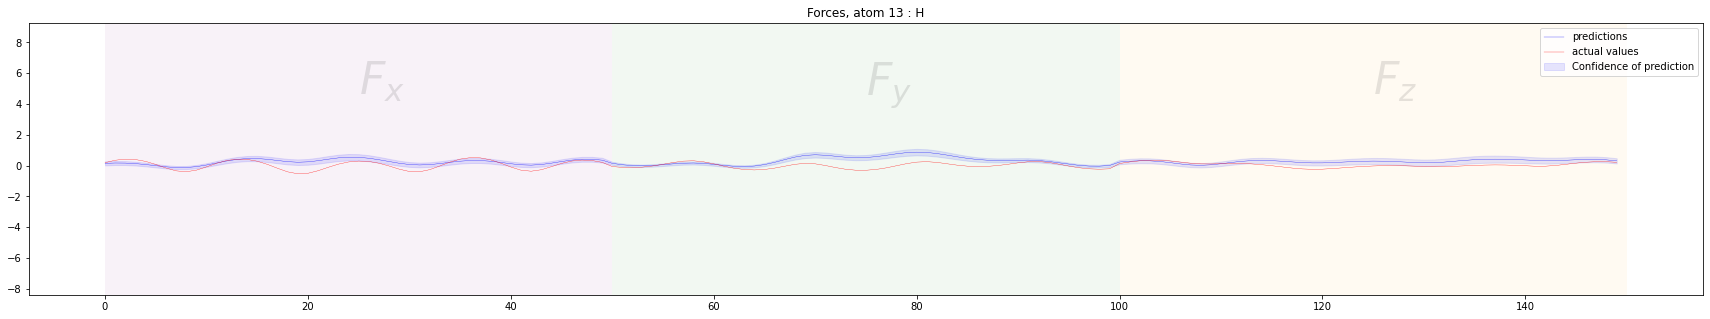

Forces MAE: 0.2838
Forces MSE: 0.1230
Cumulative uncertainty: 46.6871


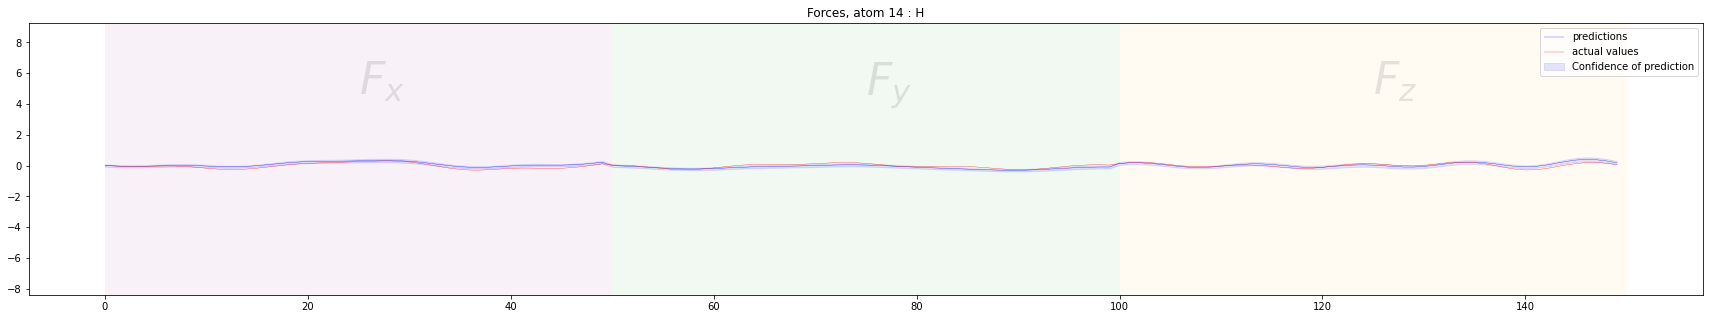

Forces MAE: 0.0971
Forces MSE: 0.0133
Cumulative uncertainty: 27.9950


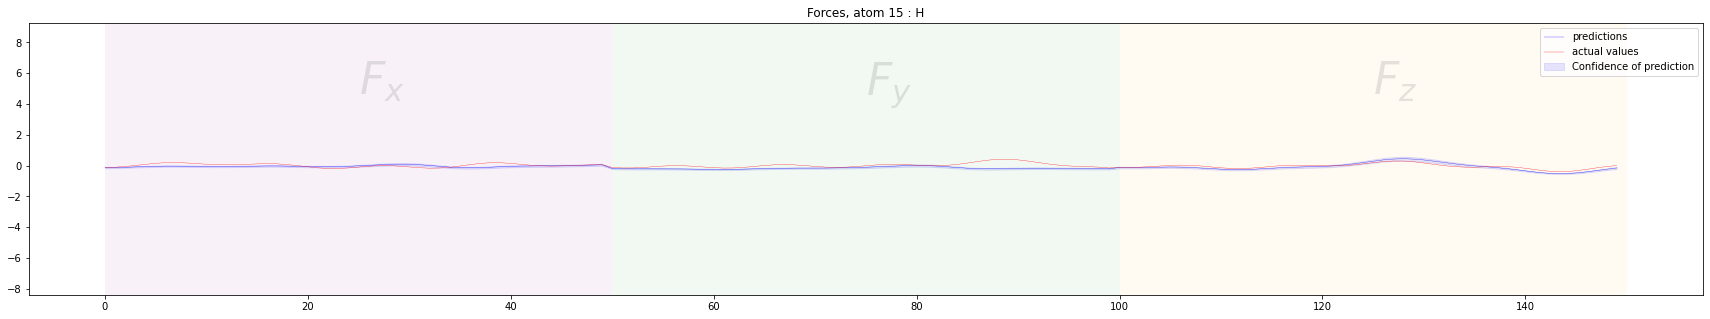

Forces MAE: 0.1349
Forces MSE: 0.0301
Cumulative uncertainty: 17.3875


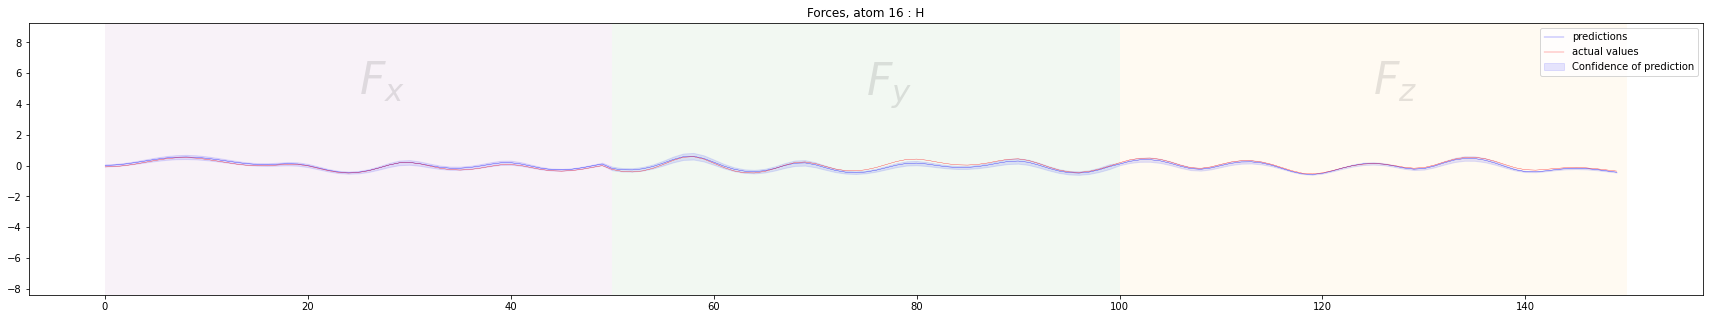

Forces MAE: 0.0821
Forces MSE: 0.0094
Cumulative uncertainty: 31.1741


In [50]:
from fande.predict import PredictorASE

test_X = fdm.test_X
test_DX = fdm.test_DX
test_E = fdm.test_E
test_F = fdm.test_F

model_e = None
trainer_e = None


predictor = PredictorASE(
        fdm,
            model_e,
            model_f,
            trainer_e,
            trainer_f,
            test_X,
            test_DX,
            test_E,
            test_F,
            test_data,
            hparams,
            soap_params
)


predictor.predict_and_plot_forces()

In [1262]:
# %%capture
from ase.units import Bohr,Hartree

test_f = []

for mol in fdm.traj_test:
        f_, f_var_ = predictor.predict_forces_single(mol)
        # print(f_[16,0])
        test_f.append(f_[16,0])

# print(f_)

# print(f_[16]) 
# print(fdm.forces_test_norm[5,16,:])

plt.plot(fdm.forces_test[:,16,0] * Hartree/Bohr)
# print(f_[:,16,0])

plt.plot(test_f)

/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Starting SOAP calculation...
SOAP calculation done!

 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1747274/1889754866.py", line 7, in <cell line: 6>
    f_, f_var_ = predictor.predict_forces_single(mol)
  File "/home/dlb/coding/shared_coding/repos/chem-gp/saddle-dynamics/notebooks/../../fande/fande/predict/predictors_ase.py", line 411, in predict_forces_single
    f_ = self.get_xtb_forces(snapshot)
  File "/home/dlb/coding/shared_coding/repos/chem-gp/saddle-dynamics/notebooks/../../fande/fande/predict/predictors_ase.py", line 494, in get_xtb_forces
    atoms_.calc = self.xtb_calc
AttributeError: 'PredictorASE' object has no attribute 'xtb_calc'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 1

### Dynamics simulation

In [ ]:
from sdynamics.dynamics import MDynamics

atoms = ... # initialize saddle structure

atoms.calc = gp_model.ase_calc() # get calc from the trained GP

md_runner = MDynamics(atoms) # instantiate class for running MD

md_runner.run() # run the MD

### Testing ASE calc

In [1279]:
%%time
from fande.ase import FandeCalc
from ase.build import molecule

from ase import io

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.INFO) # logging.ERROR to disable or INFO


logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)


atoms = fdm.traj_train[100].copy()

# atoms = molecule("CH3CH2OCH3")
fande_calc = FandeCalc(predictor)

# for a in traj: a.calc=fande_calc 
atoms.calc = fande_calc

print(atoms.get_potential_energy() )
print( atoms.get_forces())


Starting SOAP calculation...
SOAP calculation done!

 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...
-542.1639000203849
[[-0.10594412 -0.45908225 -0.29277246]
 [ 0.61034834  0.4383901   0.20935993]
 [ 0.33447332  0.82477695  0.69333589]
 [-0.11148175 -0.01252607  0.22294673]
 [ 0.15783987 -0.15579642 -0.4475599 ]
 [-0.48184219  0.12007389  0.66703446]
 [ 0.32438669  0.10934117  0.02461919]
 [-0.01063751 -0.09661806 -0.24968446]
 [ 0.03245938  0.07487417  0.00210842]
 [-0.31195693 -0.01455698 -0.57607283]
 [-0.09039736  0.12635891  0.22967071]
 [ 0.07020966 -0.11702959 -0.07040354]
 [-0.06066155 -0.22897022 -0.19885863]
 [ 0.03264087 -0.14197292  0.09067633]
 [-0.17744382 -0.14035702 -0.15111249]
 [-0.02723401  0.0483343  -0.15314693]
 [ 0.02616669  0.14953829  0.07810455]]
CPU times: user 40.1 ms, sys: 0 ns, total: 40.1 ms
Wall time: 36.5 ms


In [ ]:
### Molecular Dynamics with Fande calculator

In [29]:
%%capture
from fande.ase import FandeCalc
from sdynamics import MDRunner
import logging

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR) # logging.ERROR to disable or INFO

# atoms = fdm.mol_traj[10].copy()
atoms = fdm.traj_train[0].copy()
atoms.calc = FandeCalc(predictor)

# print( atoms.get_forces() )
# print( atoms.get_potential_energy())

mdr = MDRunner(atoms, "../data/dump/ase/md_test.xyz", "../data/dump/ase/md_log.log")
mdr.run()

In [30]:
from ase.visualize import view

traj_ml = io.read("../data/dump/asemd.traj", index=":")
view(traj_ml)

<Popen: returncode: None args: ['/home/dlb/anaconda3/envs/pyc/bin/python', '...>

Traceback (most recent call last):
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/ase/gui/pipe.py", line 28, in main
    plt.show()
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/matplotlib/pyplot.py", line 368, in show
    return _backend_mod.show(*args, **kwargs)
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/matplotlib_inline/backend_inline.py", line 41, in show
    display(
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/IPython/core/display_functions.py", line 265, in display
    print(*objs)
ValueError: I/O operation on closed file.
Exception in Tk

In [36]:
## Save Energies and forces for xtb_md

forces_xtb_md = np.zeros((len(traj_ml), 17, 3))
energies_xtb_md = np.zeros(len(traj_ml))


for i,mol in enumerate(traj_ml):
        forces_xtb_md[i] = traj_ml[i].get_forces()
        energies_xtb_md[i] = traj_ml[i].get_potential_energy()

np.save("../data/dump/forces_xtb_md.npy", forces_xtb_md)
np.save("../data/dump/energies_xtb_md.npy", energies_xtb_md)

-543.3472478324876

### Visualize:

In [519]:
from ase.visualize import view

# trj = trajectories[trj_files_basename[2]]
view(traj[0:100])
# view(traj[0:100])

<Popen: returncode: None args: ['/home/dlb/anaconda3/envs/pyc/bin/python', '...>